In [1]:
import keras.layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.10.0'

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.fashion_mnist.load_data()

In [3]:
print(train_data.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [4]:
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

In [5]:
print(train_data.shape, train_labels.shape)

(54000, 28, 28) (54000,)


label = 1


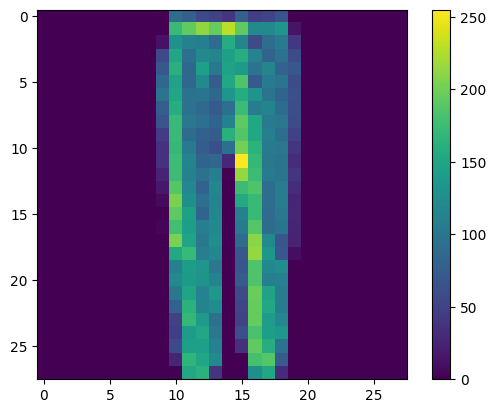

In [6]:
index = 5901
print("label = {}".format(valid_labels[index]))
plt.imshow(valid_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [7]:
train_data = train_data / 255
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

valid_data = valid_data / 255
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)

In [8]:
def one_hot_label(image, label):
    label = tf.one_hot(label, depth=10)
    return image, label

In [9]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data,valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [10]:
model = keras.Sequential([

    keras.layers.Reshape(input_shape=(28, 28), target_shape=(28, 28, 1)),

    keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(200, kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.Activation('relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10,kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.Activation('softmax')
])

In [17]:
# model = keras.Sequential([
# 
#     keras.layers.Reshape(input_shape=(28, 28), target_shape=(28, 28, 1)),
# 
#     keras.layers.Conv2D(5, (3, 3), padding='valid'),
#     layers.Activation('relu'),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Conv2D(7, (3, 3), padding='valid'),
#     layers.Activation('relu'),
#     keras.layers.Flatten(),
# 
#     keras.layers.Dense(10,kernel_initializer=tf.keras.initializers.HeUniform()),
#     layers.Activation('softmax')
# ])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              #모델 아웃풋이 logiist인 상태 자체적으로 로짓과 액티베이션을 분리해서 다양한 액티베이션으로 분석함

              metrics=['accuracy'])


In [19]:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[0.10124285 0.09947819 0.09988959 0.09969231 0.1005818  0.09926784
  0.09352664 0.10172149 0.10252732 0.10207197]]


In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 5)         50        
                                                                 
 activation_5 (Activation)   (None, 26, 26, 5)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 5)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 7)         322       
                                                                 
 activation_6 (Activation)   (None, 11, 11, 7)         0         
                                                      

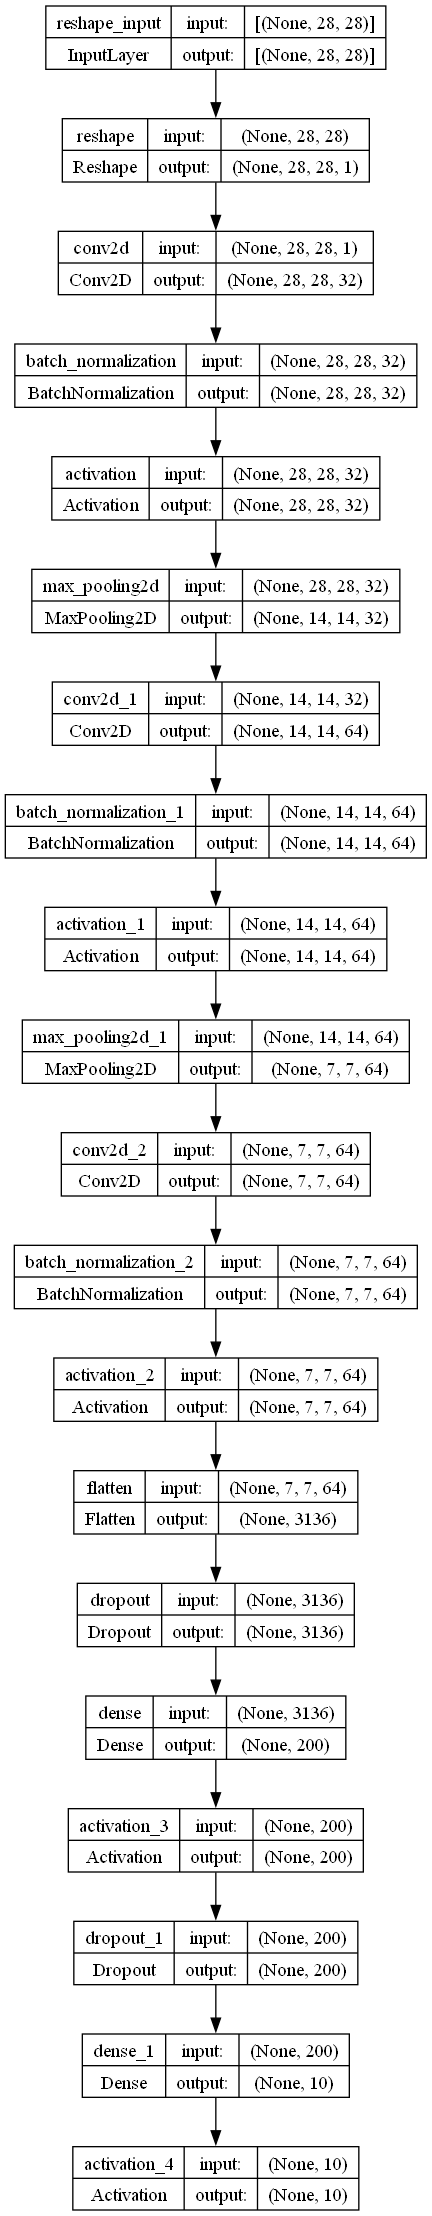

In [14]:

tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
check_point_cb = callbacks.ModelCheckpoint('fashion_mnist_model.h5',
                                           save_best_only=True,
                                           verbose=1)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True,
                                            verbose=1)

In [16]:
max_epochs = 100
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_data) // batch_size,
                    validation_data=valid_dataset,
                    validation_steps=len(valid_data) // batch_size,
                    callbacks=[check_point_cb, early_stopping_cb]
                    )

Epoch 1/100


F:\Anaconda3_envs\tensor2\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1687/1687 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.7784
Epoch 1: val_loss improved from inf to 0.38759, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 9s 4ms/step - loss: 0.6280 - accuracy: 0.7784 - val_loss: 0.3876 - val_accuracy: 0.8621
Epoch 2/100
1682/1687 [============================>.] - ETA: 0s - loss: 0.4049 - accuracy: 0.8544
Epoch 2: val_loss improved from 0.38759 to 0.33316, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 7s 4ms/step - loss: 0.4046 - accuracy: 0.8545 - val_loss: 0.3332 - val_accuracy: 0.8785
Epoch 3/100
1686/1687 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8748
Epoch 3: val_loss improved from 0.33316 to 0.30497, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 7s 4ms/step - loss: 0.3448 - accuracy: 0.8748 - val_loss: 0.3050 - val_accuracy: 0.8880
Epoch 4/100
1675/1687 [========================


KeyboardInterrupt



In [ ]:
# 코드 수정
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [ ]:
results = model.evaluate(test_dataset)